### LDA for combined captions (Posted Caption + Image_captioning generated caption) as one text
Latent Dirichlet Allocation (LDA) is a three-level hierarchical Bayesian model for topic inference. 

#### Libraries

In [1]:
#Libraries for files
#from pandas import DataFrame

from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import spatial

import re,   gensim
#from pandasql import *

# libraries for TFIDF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from gensim import corpora, models
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
np.random.seed(2018)
#nltk.download('wordnet')


import gensim
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint


# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn



Importing the posted captions from the pickled database built by Arun

Remove non-text caracters in case they exist in the text post: 

In [2]:
#Read the pickle database to get the columns for the object descriptions

import pickle

with open('instagram_database_reuters_3.pickle', 'rb') as f:
    data = pickle.load(f)

df=DataFrame(data)
df.head()


,username,postid,date,url,img_link,vid_link,caption,location_name,location_link,likes,views,image_caption,combined_caption
0,NULL,BkH69K-n1v9,2018-06-17T11:16:17.000Z,https://www.instagram.com/p/BkH69K-n1v9/,https://scontent-dfw5-1.cdninstagram.com/vp/1c...,None,People gather for an open-air yoga session nea...,NULL,NULL,8715,NONE,"a crowd of people standing on top of a field, ...",People gather for an open-air yoga session nea...
1,NULL,BembSYkHbeT,2018-01-31T04:27:39.000Z,https://www.instagram.com/p/BembSYkHbeT/,https://scontent-dfw5-1.cdninstagram.com/vp/27...,None,"North Korean defector Ji Seong-ho, currently a...",NULL,NULL,3458,NONE,a group of men standing next to each other in ...,"North Korean defector Ji Seong-ho, currently a..."
2,NULL,BpUCo6xj3ct,2018-10-24T10:51:17.000Z,https://www.instagram.com/p/BpUCo6xj3ct/,https://scontent-dfw5-1.cdninstagram.com/vp/60...,None,Men work on cables connecting power transmissi...,NULL,NULL,8232,NONE,a group of people riding skis on top of a ski ...,Men work on cables connecting power transmissi...
3,NULL,BjKcT5UH2b_,2018-05-24T14:14:50.000Z,https://www.instagram.com/p/BjKcT5UH2b_/,https://scontent-dfw5-1.cdninstagram.com/vp/3d...,None,A mahout rides his elephant in the Yamuna rive...,NULL,NULL,9371,NONE,"a man riding an elephant in the water, a man i...",A mahout rides his elephant in the Yamuna rive...
4,NULL,BczdWEFnkQr,2017-12-17T12:52:58.000Z,https://www.instagram.com/p/BczdWEFnkQr/,https://scontent-dfw5-1.cdninstagram.com/vp/f8...,None,Photographers take pictures as the Soyuz MS-07...,NULL,NULL,6184,NONE,a group of people standing next to each other ...,Photographers take pictures as the Soyuz MS-07...


In [3]:
# Create an index to refer to a sample post later as a sample document 
df['index']=data.index

# select only the variables needed in this model and create a df: 
documents = df[['combined_caption', 'likes' ,'index']]
documents.head()


,combined_caption,likes,index
0,People gather for an open-air yoga session nea...,8715,0
1,"North Korean defector Ji Seong-ho, currently a...",3458,1
2,Men work on cables connecting power transmissi...,8232,2
3,A mahout rides his elephant in the Yamuna rive...,9371,3
4,Photographers take pictures as the Soyuz MS-07...,6184,4


In [4]:

doc = documents.combined_caption

# Remove Emails
doc = [re.sub('\S*@\S*\s?', '', sent) for sent in doc]

# Remove new line characters
doc = [re.sub('\s+', ' ', sent) for sent in doc]

# Remove distracting single quotes
doc = [re.sub("\'", "", sent) for sent in doc]
# Remove #
doc = [re.sub("\#", "", sent) for sent in doc]

# Remove /
doc = [re.sub("\/", "", sent) for sent in doc]

pprint(doc[:1])

['People gather for an open-air yoga session near the Eiffel tower in Paris, '
 'France June 17, 2018. REUTERSPhilippe Wojazer paris france yoga eiffeltower '
 'reutersphotos reuters, a crowd of people standing on top of a field, a crowd '
 'of people standing on top of a sandy beach, a crowd of people standing on '
 'top of a lush green field, ']


#### Tokenization

Tokenizing using gensim library: as it has a function simple_preprocess()
Breaking up the posted text into sentences. 
After that we will tokenize each sentence into a list of words.
Gensim’s simple_preprocess() is great for this. 
deacc=True to remove the punctuations.

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words =tuple( sent_to_words(doc))

print(data_words[:1])

(['people', 'gather', 'for', 'an', 'open', 'air', 'yoga', 'session', 'near', 'the', 'eiffel', 'tower', 'in', 'paris', 'france', 'june', 'reutersphilippe', 'wojazer', 'paris', 'france', 'yoga', 'eiffeltower', 'reutersphotos', 'reuters', 'crowd', 'of', 'people', 'standing', 'on', 'top', 'of', 'field', 'crowd', 'of', 'people', 'standing', 'on', 'top', 'of', 'sandy', 'beach', 'crowd', 'of', 'people', 'standing', 'on', 'top', 'of', 'lush', 'green', 'field'],)


#### Lemmatization

Lemmatization : converting words to its root word.
The advantage of this is, we get to reduce the total number of unique words in the dictionary. 
As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns. You can expect better topics to be generated in the end.

In [6]:

stemmer = PorterStemmer()



def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
        try:
            result.remove('REUTER')
        except:
            pass
        try:
            result.remove('#REUTER')
        except:
            pass
        try:
            result.remove('reuter')
        except:
            pass
        try:
            result.remove('#reuter')
        except:
            pass
        try:
            result.remove('reutersphotos')
        except:
            pass
        try:
            result.remove('#reutersphotos')
        except:
            pass
        try:
            result.remove('reutersphoto')
        except:
            pass
        try:
            result.remove('#reutersphoto')
        except:
            pass
        try:
            result.remove('reuters')
        except:
            pass
        try:
            result.remove('#reuters')
        except:
            pass
    
    return result


In [7]:
# sample document at index 3 is being tested to see if our tokenizer and lammitizer work:

doc_sample = documents[documents['index'] == 3].values[0][0]
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')

# apply the function we defined earlier to test the sample doc:
print(preprocess(doc_sample))


original document: 
['A', 'mahout', 'rides', 'his', 'elephant', 'in', 'the', 'Yamuna', 'river', 'on', 'a', 'hot', 'summer', 'day', 'in', 'New', 'Delhi,', 'India', 'May', '24,', '2018.', 'REUTERS/Adnan', 'Abidi', '@adnanabidi', '#india', '#summer', '#newdelhi', '#reuters', '#reutersphotos,', 'a', 'man', 'riding', 'an', 'elephant', 'in', 'the', 'water,', 'a', 'man', 'is', 'riding', 'an', 'elephant', 'in', 'the', 'water,', 'a', 'man', 'riding', 'on', 'the', 'back', 'of', 'an', 'elephant,', '']


 tokenized and lemmatized document: 
['mahout', 'rid', 'eleph', 'yamuna', 'river', 'summer', 'delhi', 'india', 'adnan', 'abidi', 'adnanabidi', 'india', 'summer', 'newdelhi', 'rid', 'eleph', 'water', 'rid', 'eleph', 'water', 'rid', 'eleph']


In [8]:
#Since the test document worked we can apply to the whole set of documents we have
#Preprocess the caption text, saving the results as "data_lemmatized"

data_lemmatized  = documents['combined_caption'].map(preprocess)
data_lemmatized[:10]

0    [peopl, gather, open, yoga, session, near, eif...
1    [north, korean, defector, seong, current, stud...
2    [work, cabl, connect, power, transmiss, tower,...
3    [mahout, rid, eleph, yamuna, river, summer, de...
4    [photograph, pictur, soyuz, spacecraft, carri,...
5    [drone, carri, bag, creation, dolc, gabbana, a...
6    [month, babi, eleph, sit, insid, eleph, breed,...
7    [blacken, landscap, show, wildfir, damag, near...
8    [manchest, citi, oleksandr, zinchenko, react, ...
9    [guest, arriv, loui, vuitton, fashion, near, l...
Name: combined_caption, dtype: object

The training dataset for LDA topic model algorithm requires a document word matrix as the main input.
To create one, we will use CountVectorizer. 
In the below code, we chose to convert all words to lowercase, and remove stopwords.



Since most cells contain zeros, the result will be in the form of a sparse matrix to save memory.
If you want to materialize it in a 2D array format, call the todense() method of the sparse matrix like its done in the next step.

In [9]:
# configuring the vectorizer
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, stop_words="english", analyzer='word',  max_df=1.0, min_df=1, max_features=2000)

#APplying the the transform to our data in order to get the word matrix
data_vectorized = vectorizer.fit_transform(data_lemmatized)



8. Check the Sparsicity
Sparsicity is refering to the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.


In [10]:
#Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")


Sparsicity:  1.0243867243867244 %


#### Build LDA model with sklearn
The Latent Dirichlet Allocation (LDA) model needs to be initialised first and then we call fit_transform() to build the LDA model.
For start we set the number of topics(n-componenets) as 20 based on prior knowledge about the dataset. Later we will find the optimal number using grid search.


In [11]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=20, n_jobs=-1, n_topics=None, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


#### Model performance 
Two common measure for LDA performance measure:
1- perplexity(small is better) and 2- log-likelihood (hihg is better)


In [12]:

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())


Log Likelihood:  -137966.07165123723
Perplexity:  722.4619867839956
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### How to GridSearch the best LDA model?

The most important tuning parameter , in order of priority ,for LDA models is: 1- n_components (number of topics). 
2- I am going to search learning_decay (which controls the learning rate) .
3- learning_offset (downweigh early iterations. Should be > 1) and 4- max_iter. 

The grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

In [13]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30,50,100], 'learning_decay': [.5, .7, .9]}

In [14]:
#Supress warnings
import warnings
warnings.filterwarnings("ignore")

# Init the Model
lda = LatentDirichletAllocation()


# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)


# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30, 50, 100], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_decay': [0.5, 0.7, 0.9], 'n_topics': [10, 15, 20, 25, 30, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

#### How to see the best topic model and its parameters?

In [15]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -58647.32070638467
Model Perplexity:  765.4584542736653


#### Compare LDA Model Performance Scores

In [16]:
# Get Log Likelyhoods from Grid Search Output
n_topics =[10, 15, 20, 25, 30, 50, 100]

log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.5]
log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.7]
log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.grid_scores_ if gscore.parameters['learning_decay']==0.9]


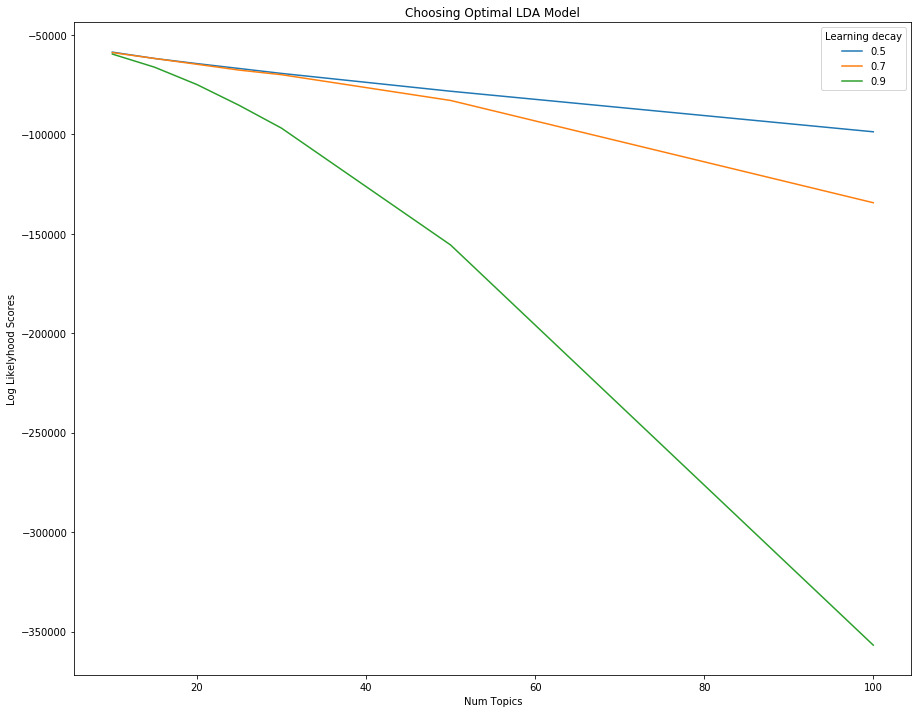

In [17]:
# Show graph
plt.figure(figsize=(15, 12))

plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


From the above plots : Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 10 has better scores. And learning_decay of 0.7 outperforms both 0.5 and 0.9.
We are thinking the reason is : even though we know that the dataset has 20 distinct topics to start with, some topics could share common keywords. For example, ‘paparazi’ and ‘photographers’ can have a lot of common words. 

So the bottom line is, a lower optimal number of distinct topics (even 10 topics) may be reasonable for this dataset. 

### How to see the dominant topic in each document?
To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.
In the table below,  all major topics in a document are written in "Green" and assigned the most dominant topic in its own column.

In [22]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)#, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic


# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

In [24]:
df_document_topics_with_likes = pd.concat((df_document_topics.data, documents['likes']), axis=1)
df_document_topics_with_likes.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic,likes
0,0.00,0.0,0.32,0.0,0.00,0.0,0.66,0.00,0.0,0.00,6,8715
1,0.23,0.0,0.00,0.0,0.04,0.0,0.71,0.00,0.0,0.00,6,3458
2,0.00,0.0,0.00,0.0,0.00,0.0,0.23,0.00,0.0,0.75,9,8232
3,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.96,9,9371
4,0.00,0.7,0.00,0.0,0.00,0.0,0.25,0.03,0.0,0.00,1,6184


In [25]:
df_document_topics_with_likes.to_pickle('combo_cap_document_topics_with_likes.pickle')

### 15. Topics distribution across documents


In [22]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution


,Topic Num,Num Documents
0,5,185
1,6,117
2,7,104
3,8,63
4,1,57
5,9,48
6,3,43
7,2,29
8,0,28
9,4,19


### Visualize the LDA model with pyLDAvis
In pyLDAvis, there is a dynamic visualization of topics-keywords distribution:
A good topic model will have non-overlapping, fairly big sized blobs for each topic.Let's see what we will get here.

In [23]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel


PreparedData(topic_coordinates=            Freq  cluster  topics           x          y
topic                                                   
5      24.426168        1       1   32.124367  59.144547
6      15.129065        1       2   97.069038  50.729824
7      14.168101        1       3   52.590923  11.267245
8      10.332384        1       4   -0.156916  -2.598197
1       8.284996        1       5   99.790176  -8.777904
9       7.810590        1       6   58.813625 -39.673485
3       7.178743        1       7   11.098851 -62.804005
2       5.365165        1       8   75.653343 -89.966385
0       4.023961        1       9  126.693497 -56.171097
4       3.280827        1      10  148.327301  10.097153, topic_info=     Category         Freq          Term        Total  loglift  logprob
term                                                                   
572   Default   161.000000           fli   161.000000  30.0000  30.0000
664   Default   588.000000         group   588.000000  29.0000  29.0000
1310  Default   511.000000         peopl   511.000000  28.0000  28.0000
1522  Default   266.000000           rid   266.000000  27.0000  27.0000
1666  Default   280.000000           sit   280.000000  26.0000  26.0000
1959  Default   213.000000         woman   213.000000  25.0000  25.0000
162   Default    68.000000         black    68.000000  24.0000  24.0000
1087  Default    60.000000        mexico    60.000000  23.0000  23.0000
706   Default   202.000000          hold   202.000000  22.0000  22.0000
1940  Default    69.000000         white    69.000000  21.0000  21.0000
1096  Default    56.000000       migrant    56.000000  20.0000  20.0000
326   Default   105.000000         clock   105.000000  19.0000  19.0000
1329  Default    64.000000         phone    64.000000  18.0000  18.0000
281   Default    59.000000          cell    59.000000  17.0000  17.0000
1684  Default   116.000000          snow   116.000000  16.0000  16.0000
1848  Default    47.000000         train    47.000000  15.0000  15.0000
880   Default    51.000000          kite    51.000000  14.0000  14.0000
1719  Default   590.000000         stand   590.000000  13.0000  13.0000
717   Default    75.000000          hors    75.000000  12.0000  12.0000
1760  Default    50.000000          suit    50.000000  11.0000  11.0000
1670  Default    78.000000    skateboard    78.000000  10.0000  10.0000
155   Default    77.000000         bench    77.000000   9.0000   9.0000
1407  Default    54.000000       protest    54.000000   8.0000   8.0000
144   Default    50.000000          bear    50.000000   7.0000   7.0000
1928  Default   124.000000         water   124.000000   6.0000   6.0000
1564  Default    72.000000        russia    72.000000   5.0000   5.0000
1843  Default    67.000000         tower    67.000000   4.0000   4.0000
1779  Default    57.000000     surfboard    57.000000   3.0000   3.0000
1742  Default   140.000000        street   140.000000   2.0000   2.0000
1512  Default  1266.000000        reuter  1266.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
1535  Topic10     2.889889       roadsid     3.750313   3.1565  -5.5652
711   Topic10     5.529788       hondura     7.591756   3.1002  -4.9163
1060  Topic10     4.986896         mckay     6.861136   3.0980  -5.0196
678   Topic10     4.983869        hannah     6.862095   3.0973  -5.0202
833   Topic10     2.307260        juarez     3.194783   3.0916  -5.7904
1552  Topic10     6.595906          rout     9.161932   3.0885  -4.7400
647   Topic10     2.298305      gonzalez     3.196827   3.0871  -5.7943
59    Topic10     5.096333      american     7.186504   3.0734  -4.9979
668   Topic10    10.024318     guatemala    14.426950   3.0530  -4.3214
1756  Topic10     1.597298       suchiat     2.451457   2.9887  -6.1581
728   Topic10     1.592605       huixtla     2.454301   2.9846  -6.1611
471   Topic10     1.582456    echeverria     2.498697   2.9603  -6.1675
1453  Topic10     6.644440       

### How to see the Topic’s keywords?
The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().
Let’s use this info to construct a weight matrix for all keywords in each topic.

In [24]:

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,abandon,abidi,abisai,aboard,abus,academi,accord,account,accus,acr,...,zhejiang,zhong,zhuhai,zhumatov,zimbabw,ziplin,zohra,zohrabensemra,zone,zuckerberg
Topic0,0.105351,0.103877,0.104245,0.103566,0.103337,0.104241,0.962742,0.103552,0.104101,2.534200,...,0.109577,0.104069,0.104195,0.103960,1.820164,0.103106,0.103808,0.103386,0.117524,0.103152
Topic1,0.103704,6.957906,0.164245,0.103642,0.103158,0.104113,0.103237,0.104245,0.111509,0.103445,...,0.103955,0.103689,0.104129,4.175213,0.103343,0.103524,0.103842,0.103044,0.103874,0.103814
Topic2,0.104667,0.104124,0.103076,0.108676,0.103106,0.103250,0.103791,0.104113,0.104663,0.103582,...,0.708192,0.104061,0.103635,0.104511,0.103830,1.110680,0.103739,0.103835,0.103358,0.103687
Topic3,0.103992,0.132363,4.955011,0.103272,1.054772,3.544926,0.124744,0.106035,1.833985,0.103720,...,0.103780,1.798288,0.103737,0.103716,0.103622,0.103501,0.875334,0.887200,0.111325,0.103278
Topic4,0.103421,0.103124,0.104248,0.103366,0.103293,0.102843,0.115979,0.103264,0.104202,0.103303,...,0.104767,0.104562,0.103454,0.103214,0.103855,0.103601,0.104129,0.103366,0.103837,0.103562


### Top 15 keywords each topic:
From the above output, we will try to see the top 15 keywords that are representative of the topic.
The show_topics() defined below creates that.
       


In [25]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15) 

In [26]:
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,black,white,train,reuter,photo,reutersphoto,track,shirt,build,stand,park,australia,india,sydney,hydrant
Topic 1,reuter,hold,reutersphoto,woman,india,stand,street,york,texa,fashion,citi,dress,hydrant,hand,open
Topic 2,fli,reuter,kite,airplan,plane,reutersphoto,stuff,anim,person,london,mountain,britain,airport,iraq,blue
Topic 3,woman,reuter,phone,sit,cell,hold,suit,reutersphoto,bench,talk,herd,hand,rohingya,bangladesh,ukrain
Topic 4,mexico,migrant,caravan,reuter,peopl,group,central,reutersphoto,octob,guatemala,state,boat,america,unit,ciudad
Topic 5,reuter,group,stand,peopl,sit,reutersphoto,beach,water,bird,larg,tabl,bodi,build,bench,boat
Topic 6,reuter,rid,reutersphoto,clock,skateboard,hors,tower,street,build,road,stand,larg,california,middl,person
Topic 7,group,reuter,peopl,stand,reutersphoto,snow,cover,russia,walk,field,ski,slope,rid,soccer,play
Topic 8,reuter,stand,reutersphoto,protest,gaza,group,field,eleph,tenni,peopl,palestinian,court,israel,citi,green
Topic 9,reuter,bear,rid,surfboard,wave,reutersphoto,girl,person,water,teddi,sit,littl,snowboard,snow,hold
